# Importación de Librerías

In [1]:
#Librerias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout
from google.colab.patches import cv2_imshow
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, ReLU, Flatten, Dense,BatchNormalization 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint
import random 
from keras.layers import GlobalAveragePooling2D


# Importación de Imagenes desde GitHub


In [2]:
#Clonar Repositorio (Aproximadamente 6 minutos)
!git clone https://github.com/egarma27/Modelo41.git

Cloning into 'Modelo41'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 69 (delta 2), reused 17 (delta 2), pack-reused 52
Unpacking objects: 100% (69/69), done.
Checking out files: 100% (15/15), done.


In [3]:
#Carpeta del Repositorio
%cd /content/Modelo41

/content/Modelo41


Imagenes de 128x128

In [4]:
!unzip 'low-resolution01.zip'
!unzip 'low-resolution02.zip'
!unzip 'low-resolution03.zip'
!unzip 'low-resolution04.zip'
!unzip 'low-resolution05.zip'
!unzip 'low-resolution06.zip'
!unzip 'low-resolution07.zip'
!unzip 'low-resolution08.zip'
!unzip 'low-resolution09.zip'
!unzip 'low-resolution10.zip'


Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: 7449-n000128-teddy/n164152.jpeg  
  inflating: 7449-n000128-teddy/n164153.jpeg  
  inflating: 7449-n000128-teddy/n164154.jpeg  
  inflating: 7449-n000128-teddy/n164155.jpeg  
  inflating: 7449-n000128-teddy/n164156.jpeg  
  inflating: 7449-n000128-teddy/n164157.jpg  
  inflating: 7449-n000128-teddy/n164158.jpg  
  inflating: 7449-n000128-teddy/n164159.jpg  
  inflating: 7449-n000128-teddy/n164160.jpg  
  inflating: 7449-n000128-teddy/n164161.jpg  
  inflating: 7449-n000128-teddy/n164162.jpg  
  inflating: 7449-n000128-teddy/n164163.jpg  
  inflating: 7449-n000128-teddy/n164164.jpg  
  inflating: 7449-n000128-teddy/n164165.jpg  
  inflating: 7449-n000128-teddy/n164166.jpg  
  inflating: 7449-n000128-teddy/n164167.jpg  
  inflating: 7449-n000128-teddy/n164168.jpg  
  inflating: 7449-n000128-teddy/n164169.jpg  
  inflating: 7449-n000128-teddy/n164170.jpeg  
  inflating: 7449-n000128-teddy/n164171.jpeg  
  infl

# Carga de Datos de Entrenamiento

In [5]:
#Definición de Carga de rutas de fotos y su tipo en Entrenamiento
def cargaImagenesTipos(path):
  filenames=[]
  tipos=[]
  with open(path) as fp:
      line = fp.readline()
      while line:
        line = line.strip()
        a, ruta = line.split(".//")
        a,b,c = ruta.split("-")
        tipo,b = c.split("/")
        filenames.append(ruta)
        tipos.append(tipo)
        line = fp.readline()
  return filenames,tipos
 
#Define función de carga de imágenes
def cargaImagenes(filenames,path):
  images = []
  for filename in filenames:
    img = cv2.imread(os.path.join(path,filename))
    if img is not None:     
      images.append(img)
  return images

In [6]:
#Carga de nombres y tipos de perros desde archivos del entrenamiento (20 Razas)
train_filenames, train_tipos = cargaImagenesTipos("/content/Modelo41/train20.lst") 

#Define tamaño de redimensionamiento de imagenes 128x128 px
img_size = 128

In [7]:
#Carga de imágenes del entrenamiento
imagesT = cargaImagenes(train_filenames,"/content/Modelo41/") 

In [8]:
#Numero Total de Imagenes en las 20 Razas
numLen=len(imagesT)
numLen

3342

# Funciones de Data Augmentation

In [9]:
#Funcion de Cambio de Canales
def channel_shift(img, value):
    value = int(random.uniform(-value, value))
    img = img + value
    img[:,:,:][img[:,:,:]>255]  = 255
    img[:,:,:][img[:,:,:]<0]  = 0
    img = img.astype(np.uint8)
    return img

#Funcion de Cambio de Brillo
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

#Funcion de Rotacion de Imagenes
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

In [10]:
#DATA AUGMENTATION

#Duplicamos las Imagenes
numAumentar=numLen
imagesdt=imagesT[0:numAumentar]
dataAugmentation=[]

for img in imagesdt:
  #Decision aleatoria para aplicar al duplicado
  numRandom = random.choice([0,1,2])
  #Horizontal Flip
  if(numRandom==0):  
    imgAux=cv2.flip(img,1)
  #Rotacion de -10 Grados
  if(numRandom==1):  
   imgAux=rotation(img,-10)
  #Rotacion de 10 Grados
  if(numRandom==2):  
    imgAux=rotation(img, 10)


     #if(numRandom==1):  
  # imgAux=brightness(img, 0.5, 3)
  #if(numRandom==2):  
  #  imgAux=cv2.flip(img, 0) 
  #if(numRandom==4):  
  #  imgAux=channel_shift(img, 60)

  dataAugmentation.append(imgAux)

imagesT=imagesT+dataAugmentation

train_tipos=train_tipos+train_tipos[0:numAumentar]


In [11]:
#Nuevo Numero Total de Imagenes 
(len(imagesT),len(train_tipos))

(6684, 6684)

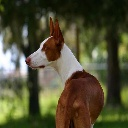

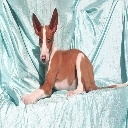

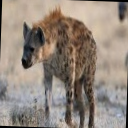

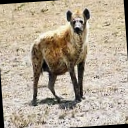

In [12]:
#Imprime ejemplo de Perros para comprobar su carga exitosa
cv2_imshow(imagesT[0])
cv2_imshow(imagesT[10])
cv2_imshow(imagesT[-13])
cv2_imshow(imagesT[-1])

# Normalizacion

In [13]:
#Define función para visualizar gráficas: Épocas vs pérdida y Épocas vs precisión
def show_results(log):
    val_loss = log.history['val_loss']
    val_acc = log.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['accuracy'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()
    
#Define funciones para el normalizado
def normalizar(images):
  images=np.asarray(images)

  images = images / 255.
  mean = 0.5
  std = 0.5
  images = (images - mean) / std
  return images

def denormalizar(images):
  return (images*std+mean)*255

In [14]:
#Normalizamos las imágenes
imagesT = normalizar(imagesT)

In [15]:
#Creamos un diccionario de acuerdo al tipo de perro
tipos = list(set(train_tipos)) 
tiposid = {name: i for i, name in enumerate(tipos)}

tipos_total=len(tiposid)
#Numero de Razas
tipos_total

20

In [16]:
#Generamos las salidas de acuerdo al diccionario
train_outputs=[]
for image_id in train_tipos:
  breed_idx = tiposid[image_id]
  train_outputs.append(breed_idx)

train_outputs = np.array(train_outputs)

In [17]:
#Comprobamos dimensiones de las imágenes de prueba
imagesT.shape

(6684, 128, 128, 3)

In [18]:
#Comprobamos dimensiones de las salidas de prueba
train_outputs.shape

(6684,)

# Creacion de Grupos de Entrenamiento y Validacion

In [19]:
# Separamos las imágenes en conjuntos de entrenamiento y validación (Proporcion 80%-20%)
x_train, x_val, y_train, y_val = train_test_split(imagesT, train_outputs, test_size=0.2, random_state=42)


In [20]:
#Comprobamos dimensiones de los conjuntos generados
x_train.shape , x_val.shape

((5347, 128, 128, 3), (1337, 128, 128, 3))

In [21]:
y_train.shape , y_val.shape

((5347,), (1337,))

In [22]:
#Definimos el tamaño del Batch
bs = 32

#Mezcla las imágenes y se generan los conjunto de datos de prueba y validación
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = dataset_train.shuffle(buffer_size=100).batch(bs).prefetch(50)
dataset_test = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataset_test = dataset_test.batch(bs).prefetch(50)

# Modelo

In [23]:
#MODELO
def create_model(tl='I'):
  #Incorporación de capas convolucionales utilizando Transfer Learning
  if tl=='I':
    base_model = InceptionV3(include_top=False,weights='imagenet', input_shape=(img_size, img_size, 3))
  elif tl=='R':
    base_model = ResNet50(include_top=False, input_shape=(img_size, img_size, 3))
  base_model.trainable = False
  
  #Incorporamos capas densas
  model = Sequential()
  
  model.add(Dense(1024, input_shape=(2048,), activation="relu",kernel_initializer='he_normal',use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation="relu",kernel_initializer='he_normal',use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(tipos_total, activation="softmax"))

  #Combinamos capas convolucionales y densas para formar el modelo final
  final_model = Sequential()
  final_model.add(base_model)
  final_model.add(GlobalAveragePooling2D())
  final_model.add(model)
  return final_model

In [24]:
#Definición de hiperparámetros
lr = 0.001
momentum = 0.9

#Creación y compilación del modelo
model = create_model()
model.compile(optimizer=SGD(learning_rate=lr,momentum=momentum), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


In [25]:
#Visualizamos el modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 2048)              0         
_________________________________________________________________
sequential (Sequential)      (None, 20)                2637844   
Total params: 24,440,628
Trainable params: 2,634,772
Non-trainable params: 21,805,856
_________________________________________________________________


In [26]:
#Establece puntos de guardado para los mejores pesos registrados
checkpoint_path = "my_model/model"
monitor = "val_accuracy"
mode = "max"

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor=monitor, verbose=1, 
                                   save_best_only=True, save_weights_only=True, 
                                   mode=mode)

# Entrenamiento

In [27]:
#Carga pesos del mejor resultado
#model.load_weights(checkpoint_path)

#Entrena el modelo
history= []
history = model.fit(dataset_train, batch_size=bs, epochs=100,
                    validation_data=dataset_test,callbacks=[model_checkpoint])

Epoch 1/100
168/168 [==============================] - 44s 61ms/step - loss: 2.4501 - accuracy: 0.3449 - val_loss: 1.2927 - val_accuracy: 0.6081

Epoch 00001: val_accuracy improved from -inf to 0.60808, saving model to my_model/model
Epoch 2/100
168/168 [==============================] - 8s 49ms/step - loss: 1.5325 - accuracy: 0.5382 - val_loss: 1.0880 - val_accuracy: 0.6515

Epoch 00002: val_accuracy improved from 0.60808 to 0.65146, saving model to my_model/model
Epoch 3/100
168/168 [==============================] - 8s 45ms/step - loss: 1.3160 - accuracy: 0.6074 - val_loss: 1.0289 - val_accuracy: 0.6784

Epoch 00003: val_accuracy improved from 0.65146 to 0.67838, saving model to my_model/model
Epoch 4/100
168/168 [==============================] - 8s 45ms/step - loss: 1.1866 - accuracy: 0.6267 - val_loss: 0.9739 - val_accuracy: 0.7053

Epoch 00004: val_accuracy improved from 0.67838 to 0.70531, saving model to my_model/model
Epoch 5/100
168/168 [==============================] - 8s 

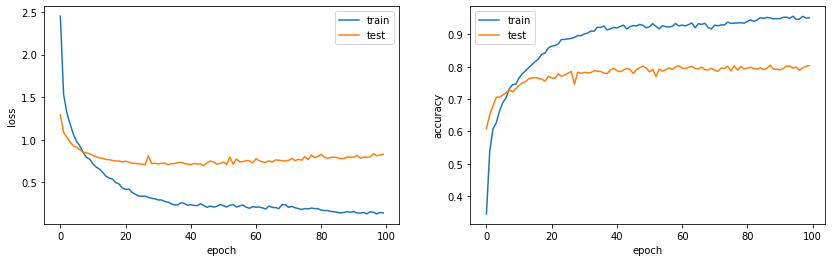

In [28]:
#Muestra los resultados, Grafica de Perdida y Grafica de Precision
show_results(history)

# Carga de Imagenes para las Predicciones

In [29]:
#Carga de nombres y tipos de perros desde archivos
test_filenames, test_tipos = cargaImagenesTipos("/content/Modelo41/validation20.lst")
#Carga imágenes
test_images = cargaImagenes(test_filenames,"/content/Modelo41/")

# Predicciones

In [30]:
#Definimos la función para realizar la prueba
def get_class( random_image, dictInverso, model,n,test_tipos):
  
  #Mostrar la imagen
  cv2_imshow(random_image)

  #Cambiar a formato numpy
  x = np.asarray(random_image, np.float32)
  x = x[None]
  #Normalizar Imagen
  x = x / 255.
  mean = 0.5
  std = 0.5
  x = (x - mean) / std  
  
  #Obtener la predicción
  y = model(x)
  
  #Decodificar la predicción
  pred = dictInverso[np.argmax(y)]
  
  real = test_tipos[n]
  
  print(f"Real value = {real} - Model prediction = {pred}")

In [31]:
#Diccionario Inverso
dictInverso= dict(zip(tiposid.values(),tiposid.keys()))

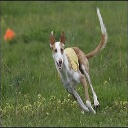

Real value = Ibizan_hound - Model prediction = Staffordshire_bullterrier


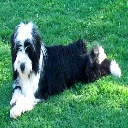

Real value = Tibetan_terrier - Model prediction = Tibetan_terrier


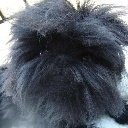

Real value = affenpinscher - Model prediction = affenpinscher


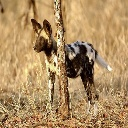

Real value = African_hunting_dog - Model prediction = African_hunting_dog


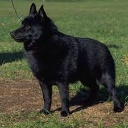

Real value = schipperke - Model prediction = schipperke


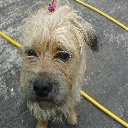

Real value = Border_terrier - Model prediction = Border_terrier


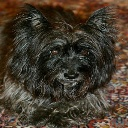

Real value = cairn - Model prediction = cairn


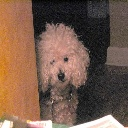

Real value = miniature_poodle - Model prediction = miniature_poodle


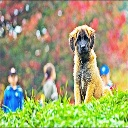

Real value = Leonberg - Model prediction = Leonberg


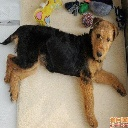

Real value = Airedale - Model prediction = Airedale


In [32]:
#Definimos parametros para la prueba
number_of_images_to_test = 10

#Realizamos una prueba
for _ in range(number_of_images_to_test):
  n=random.randint(0, len(test_images))
  random_image = test_images[n]
  
  get_class(random_image, dictInverso, model,n,test_tipos)

# Referencias

In [ ]:
#Referencias        
@article{Zou2020ThuDogs,
  title={A new dataset of dog breed images and a benchmark for fine-grained classification},
  author={Zou, Ding-Nan and Zhang, Song-Hai and Mu, Tai-Jiang and Zhang, Min},
  journal={Computational Visual Media},
  year={2020},
  url={https://doi.org/10.1007/s41095-020-0184-6}
}